First, we'll grab the JSON data of celebrity deaths from USA Today:

In [83]:
import pandas as pd 

celebrities_df = pd.read_csv('data/celebrity_deaths.csv', header=0, parse_dates=['birthdate', 'deathdate'])

# GPT-4 Turbo's official knowledge cutoff is April 2023, so we'll analyze the quality of its knowledge for the 6 months prior to that.
# We'll also include some deaths after its knowledge cutoff to test if has any knowledge of those events.
celebrities_df = celebrities_df[(celebrities_df['deathdate'] >= '2022-01-01') & (celebrities_df['deathdate'] < '2023-08-01')]
celebrities_df['death_year_month'] = celebrities_df['deathdate'].dt.strftime('%Y-%m')
celebrities_df = celebrities_df.sort_values('deathdate').reset_index(drop = True)
celebrities_df

,name,birthdate,deathdate,death_year_month
0,Dan Reeves,1944-01-19,2022-01-01,2022-01
1,Sidney Poitier,1927-02-20,2022-01-06,2022-01
2,Peter Bogdanovich,1939-07-30,2022-01-06,2022-01
3,Bob Saget,1956-05-17,2022-01-09,2022-01
4,Robert Durst,1943-04-12,2022-01-10,2022-01
...,...,...,...,...
163,Bobby Osborne,1931-12-07,2023-06-27,2023-06
164,Alan Arkin,1934-03-26,2023-06-29,2023-06
165,Tony Bennett,1926-08-03,2023-07-21,2023-07
166,Sinead O'Connor,1966-12-08,2023-07-26,2023-07


In [90]:
celebrities_df_year_month_counts_df = celebrities_df.groupby('death_year_month')['name'].count().reset_index()
celebrities_df_year_month_counts_df.columns = ['year_month', 'celebrity_count']
celebrities_df_year_month_counts_df

,year_month,celebrity_count
0,2022-01,13
1,2022-02,6
2,2022-03,7
3,2022-04,16
4,2022-05,10
5,2022-06,8
6,2022-07,10
7,2022-08,7
8,2022-09,6
9,2022-10,8


# Now lets generate the actual prompt we'll give to ChatGPT

In [82]:
# Note that we include the celebrity's birthdate to avoid any issues that may arise from celebrities with common names
prompt = (
    "Given a list of celebrity names and their birth dates, generate a JSON object containing their death dates.\n" 
    "For example, given 'Michael Jackson (1958-08-28)', you should output: { \"Michael Jackson\": \"2009-06-25\" }\n" +
    "If the person is still alive, return a blank string for their death date.\n\n" +
    "Now, return a JSON object containing every celebrity in this list:\n\n" + 
    "\n".join(f"{index + 1}. {row.name} ({row.birthdate.strftime('%Y-%m-%d')})" for index, row in enumerate(celebrities_df.itertuples()))
)
    
print(prompt)

Given a list of celebrity names and their birth dates, generate a JSON object containing their death dates.
For example, given 'Michael Jackson (1958-08-28)', you should output: { "Michael Jackson": "2009-06-25" }
If the person is still alive, return a blank string for their death date.

Now, return a JSON object containing every celebrity in this list:

1. Dan Reeves (1944-01-19)
2. Sidney Poitier (1927-02-20)
3. Peter Bogdanovich (1939-07-30)
4. Bob Saget (1956-05-17)
5. Robert Durst (1943-04-12)
6. Don Maynard (1935-01-25)
7. Ronnie Spector (1943-08-10)
8. André Leon Talley (1948-10-16)
9. Peter Robbins (1956-08-10)
10. Meat Loaf (1947-09-27)
11. Louie Anderson (1953-03-24)
12. Moses J. Moseley (1991-12-24)
13. Howard Hesseman (1940-02-27)
14. Gerald Williams (1966-08-10)
15. Betty Davis (1945-07-26)
16. Jeremy Giambi (1974-09-30)
17. Ivan Reitman (1946-10-27)
18. Sally Kellerman (1937-06-02)
19. Ned Eisenberg (1957-01-13)
20. Alan Ladd, Jr. (1937-10-22)
21. Emilio Delgado (1940-05-

In [78]:
for name in celebrities_df['name']:
    print(name)

Dan Reeves
Sidney Poitier
Peter Bogdanovich
Bob Saget
Robert Durst
Don Maynard
Ronnie Spector
André Leon Talley
Peter Robbins
Meat Loaf
Louie Anderson
Moses J. Moseley
Howard Hesseman
Gerald Williams
Betty Davis
Jeremy Giambi
Ivan Reitman
Sally Kellerman
Ned Eisenberg
Alan Ladd, Jr.
Emilio Delgado
Traci Braxton
William Hurt
Scott Hall
Madeleine Albright
Taylor Hawkins
Estelle Harris
Bobby Rydell
Rayfield Wright
Jack Higgins
Dwayne Haskins
Gary Brown (NFL)
Cedric McMillan
Gilbert Gottfried
Shirley Spork
Mike Bossy
Liz Sheridan
Daryle Lamonica
Guy Lafleur
Orrin Hatch
Jossara Jinaro
Naomi Judd
Norman Mineta
George Pérez
Mickey Gilley
Fred Ward
Adreian Payne
Bob Lanier
Ray Liotta
Andy Fletcher
Alan White
Bo Hopkins
Marion Barber
Jim Seals
Billy Kametz
Philip Baker Hall
Tony Siragusa
Mary Mara
Joe Turkel
Marlin Briscoe
Lenny Von Dohlen
James Caan
Shinzo Abe
Tony Sirico
Ivana Trump
Rebecca Balding
Paul Sorvino
Tony Dow
Bill Russell
Nichelle Nichols
Vin Scully
Roger E. Mosley
Olivia Newton-Jo

A few variables you can configure that we'll reference throughout this analysis:

In [3]:
model_name = 'gpt-4-1106-preview'
official_knowledge_cutoff = '2023-04-01'
temperatures = [0, 0.25, 0.5, 0.75, 1]
attempts_per_temperature = 10

Lets see what ChatGPT thinks...

In [4]:
import json
from openai import OpenAI

client = OpenAI()

results = []
for temperature in temperatures:
    for attempt in range(1, attempts_per_temperature + 1):
        print(f'Attempt #{attempt} for temperature {temperature}...')
        
        try:
            response = client.chat.completions.create(
                messages=[{
                    'role': 'user',
                    'content': prompt,
                }],
                model=model_name,
                temperature=temperature,
                response_format={ 'type': 'json_object' }
            )

            response_json = response.choices[0].message.content
            response_dict = json.loads(response_json)
            print(f'  Results: {len(response_dict)}')

            # Note that occasionally the JSON response won't include a key for some of the celebrities
            # we inquired about. One option is to assume GPT means they are still alive, but I think it's
            # safer just not to factor them into the analysis, since GPT's lack of a response is ambiguous.
            for name, gpt_deathdate in response_dict.items():
                results.append({
                    'temperature': temperature, 
                    'name': name, 
                    'gpt_deathdate': gpt_deathdate
                })
        except json.JSONDecodeError:
            print('  JSON parsing error; skipping')

gpt_results = pd.DataFrame(results, columns=['temperature', 'name', 'gpt_deathdate'])
gpt_results['gpt_deathdate'] = pd.to_datetime(gpt_results['gpt_deathdate'], errors='coerce')
gpt_results.to_csv(f'output/{model_name}.csv', index=0)

gpt_results

Attempt #1 for temperature 0...
  Results: 168
Attempt #2 for temperature 0...
  Results: 168
Attempt #3 for temperature 0...
  Results: 168
Attempt #4 for temperature 0...
  Results: 168
Attempt #5 for temperature 0...
  Results: 168
Attempt #6 for temperature 0...
  Results: 168
Attempt #7 for temperature 0...
  Results: 168
Attempt #8 for temperature 0...
  Results: 168
Attempt #9 for temperature 0...
  Results: 168
Attempt #10 for temperature 0...
  Results: 168
Attempt #1 for temperature 0.25...
  Results: 168
Attempt #2 for temperature 0.25...
  Results: 168
Attempt #3 for temperature 0.25...
  Results: 168
Attempt #4 for temperature 0.25...
  Results: 168
Attempt #5 for temperature 0.25...
  Results: 168
Attempt #6 for temperature 0.25...
  Results: 168
Attempt #7 for temperature 0.25...
  Results: 168
Attempt #8 for temperature 0.25...
  Results: 168
Attempt #9 for temperature 0.25...
  Results: 168
Attempt #10 for temperature 0.25...
  Results: 168
Attempt #1 for temperature 0

,temperature,name,gpt_deathdate
0,0.0,Dan Reeves,2022-01-01
1,0.0,Sidney Poitier,2022-01-06
2,0.0,Peter Bogdanovich,2022-01-06
3,0.0,Bob Saget,2022-01-09
4,0.0,Robert Durst,2021-01-10
...,...,...,...
8395,1.0,Bobby Osborne,NaT
8396,1.0,Alan Arkin,NaT
8397,1.0,Tony Bennett,NaT
8398,1.0,Sinead O'Connor,NaT


View the results for a specific celebrity:

In [21]:
gpt_results[gpt_results['name'] == 'Vida Blue']

,temperature,name,gpt_deathdate
148,0.00,Vida Blue,NaT
316,0.00,Vida Blue,NaT
484,0.00,Vida Blue,NaT
652,0.00,Vida Blue,NaT
820,0.00,Vida Blue,NaT
988,0.00,Vida Blue,NaT
1156,0.00,Vida Blue,NaT
1324,0.00,Vida Blue,NaT
1492,0.00,Vida Blue,NaT
1660,0.00,Vida Blue,NaT


Next, well merge the actual death dates with GPT results and add some columns to reflect the accuracy of GPT's results

In [41]:
merged_df = pd.merge(celebrities_df[['name', 'deathdate']], gpt_results, on='name', how='left')
merged_df = merged_df.rename(columns={'deathdate': 'actual_deathdate'})
merged_df['date_difference'] = (merged_df['gpt_deathdate'] - merged_df['actual_deathdate']).dt.days
merged_df['abs_date_difference'] = merged_df['date_difference'].abs()
merged_df['is_accurate'] = merged_df['abs_date_difference'].le(5)

# We'll need these later
merged_df['year_month'] = merged_df['actual_deathdate'].dt.strftime('%Y-%m')
merged_df['year_month_formatted'] = merged_df['actual_deathdate'].dt.strftime('%b %Y')

merged_df.to_csv('output/merged_df.csv')
merged_df

,name,actual_deathdate,temperature,gpt_deathdate,date_difference,abs_date_difference,is_accurate,year_month,year_month_formatted
0,Dan Reeves,2022-01-01,0.0,2022-01-01,0.0,0.0,True,2022-01,Jan 2022
1,Dan Reeves,2022-01-01,0.0,2022-01-01,0.0,0.0,True,2022-01,Jan 2022
2,Dan Reeves,2022-01-01,0.0,2022-01-01,0.0,0.0,True,2022-01,Jan 2022
3,Dan Reeves,2022-01-01,0.0,2022-01-01,0.0,0.0,True,2022-01,Jan 2022
4,Dan Reeves,2022-01-01,0.0,2022-01-01,0.0,0.0,True,2022-01,Jan 2022
...,...,...,...,...,...,...,...,...,...
8352,Paul Reubens,2023-07-30,1.0,NaT,NaN,NaN,False,2023-07,Jul 2023
8353,Paul Reubens,2023-07-30,1.0,NaT,NaN,NaN,False,2023-07,Jul 2023
8354,Paul Reubens,2023-07-30,1.0,NaT,NaN,NaN,False,2023-07,Jul 2023
8355,Paul Reubens,2023-07-30,1.0,NaT,NaN,NaN,False,2023-07,Jul 2023


In [66]:
merged_df.groupby('name').count() #.to_csv('output/counts.csv')

,actual_deathdate,temperature,gpt_deathdate,date_difference,abs_date_difference,is_accurate,year_month,year_month_formatted
name,,,,,,,,
Aaron Carter,50,50,49,49,49,50,50,50
Adam Rich,50,50,49,49,49,50,50,50
Adreian Payne,50,50,49,49,49,50,50,50
Al Jaffee,50,50,0,0,0,50,50,50
Alan Arkin,50,50,0,0,0,50,50,50
...,...,...,...,...,...,...,...,...
Vida Blue,50,50,0,0,0,50,50,50
Vin Scully,50,50,50,50,50,50,50,50
Vince Dooley,50,50,50,50,50,50,50,50


In [67]:
merged_df.groupby('year_month').count() #.to_csv('output/counts.csv')

,name,actual_deathdate,temperature,gpt_deathdate,date_difference,abs_date_difference,is_accurate,year_month_formatted
year_month,,,,,,,,
2022-01,650,650,650,630,630,630,650,650
2022-02,300,300,300,277,277,277,300,300
2022-03,350,350,350,350,350,350,350,350
2022-04,800,800,800,788,788,788,800,800
2022-05,500,500,500,497,497,497,500,500
2022-06,400,400,400,392,392,392,400,400
2022-07,500,500,500,491,491,491,500,500
2022-08,350,350,350,347,347,347,350,350
2022-09,300,300,300,291,291,291,300,300


To evaluate whether GPT knows about the deaths at all (in any of the results), we'll grab the closest GPT result for each celebrity:

## Viewing results for a specific celebrity

In [65]:
merged_df[merged_df['name'] == 'Vida Blue']

,name,actual_deathdate,temperature,gpt_deathdate,date_difference,abs_date_difference,is_accurate,year_month,year_month_formatted
7357,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7358,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7359,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7360,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7361,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7362,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7363,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7364,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7365,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023
7366,Vida Blue,2023-05-06,0.00,NaT,NaN,NaN,False,2023-05,May 2023


Here, for anyone curious, is a list of all the celebrities whose deaths GPT knew about:

In [7]:
celebrity_deaths_final_df[celebrity_deaths_final_df['is_accurate'] == True]

,name,birthdate,actual_deathdate,gpt_deathdate,date_difference,abs_date_difference,is_accurate
0,Dan Reeves,1944-01-19,2022-01-01,2022-01-01,0.0,0.0,True
1,Sidney Poitier,1927-02-20,2022-01-06,2022-01-06,0.0,0.0,True
2,Peter Bogdanovich,1939-07-30,2022-01-06,2022-01-06,0.0,0.0,True
3,Bob Saget,1956-05-17,2022-01-09,2022-01-09,0.0,0.0,True
4,Robert Durst,1943-04-12,2022-01-10,2022-01-10,0.0,0.0,True
...,...,...,...,...,...,...,...
135,Bud Grant,1927-05-20,2023-03-11,2023-03-11,0.0,0.0,True
136,Joe Pepitone,1940-10-09,2023-03-13,2023-03-13,0.0,0.0,True
137,Bobby Caldwell,1951-08-15,2023-03-14,2023-03-14,0.0,0.0,True
138,Lance Reddick,1962-06-07,2023-03-17,2023-03-17,0.0,0.0,True


And here are celebrities whose deaths it did not know accurately prior to GPT-4 Turbo's knowledge cutoff date. In a perfect world, there wouldn't be any results here.

In [10]:
inaccurate_before_cutoff_df = celebrity_deaths_final_df[(celebrity_deaths_final_df['is_accurate'] == False) & (celebrity_deaths_final_df["actual_deathdate"] < official_knowledge_cutoff)]
inaccurate_before_cutoff_df.sort_values('actual_deathdate')

,name,birthdate,actual_deathdate,gpt_deathdate,date_difference,abs_date_difference,is_accurate
112,Lola Chantrelle Mitchell,1979-08-07,2023-01-01,NaT,NaN,NaN,False
140,Ryuichi Sakamoto,1952-01-17,2023-03-28,NaT,NaN,NaN,False


In [12]:
', '.join(inaccurate_before_cutoff_df['name'].tolist())

'Lola Chantrelle Mitchell, Ryuichi Sakamoto'

## Accuracy by temperature

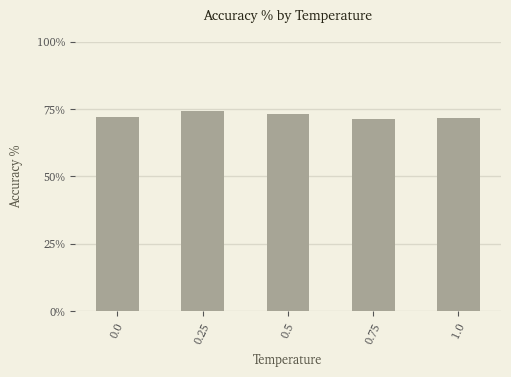

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.transforms as transforms

accuracy_by_temperature = merged_df.groupby('temperature')['is_accurate'].mean() * 100
accuracy_by_temperature_df = pd.DataFrame(accuracy_by_temperature).reset_index()
accuracy_by_temperature_df.columns = ['temperature', 'accuracy_percent']
accuracy_by_temperature_df = accuracy_by_temperature_df.sort_values('temperature', ascending=True)

matplotlib.rcParams['font.family'] = 'Charter'

plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.set_facecolor('#f3f1e2')
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.yaxis.grid(True, color='#DAD8C9', linestyle='-', linewidth=1)

accuracy_by_temperature_df.plot(kind='bar', ax=ax, x='temperature', y='accuracy_percent', figsize=(5.5, 3.5), color='#A7A596', zorder=2, legend=False)

ax.grid(color='#f3f1e2', axis='x', linestyle='-', linewidth=2)
plt.gcf().set_facecolor('#f3f1e2')

plt.title(f'Accuracy % by Temperature', fontsize=10, color='#272516', y=1.05)
plt.xlabel('Temperature', fontsize=9, color='#5A5849', labelpad=6)
plt.ylabel('Accuracy %', fontsize=9, color='#5A5849', labelpad=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=65, fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 100)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('output/temperature_accuracy_chart.png', bbox_inches='tight')

plt.show()


## What % of the time did it get the correct result for each celebrity?

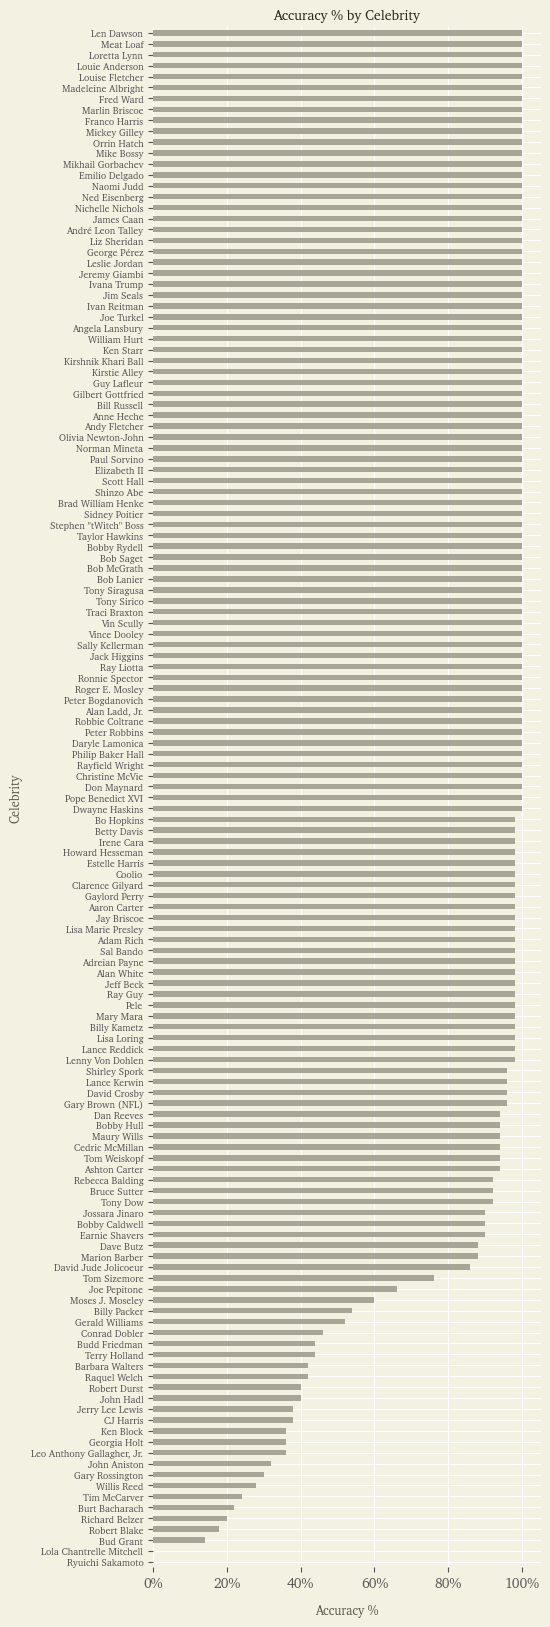

In [95]:
celebrities_before_cutoff_df = merged_df[merged_df['actual_deathdate'] < official_knowledge_cutoff]
accuracy_by_celebrity = merged_df[merged_df['actual_deathdate'] < official_knowledge_cutoff].groupby('name')['is_accurate'].mean() * 100
accuracy_by_celebrity_df = pd.DataFrame(accuracy_by_celebrity).reset_index()
accuracy_by_celebrity_df.columns = ['name', 'accuracy_percent']
accuracy_by_celebrity_df = accuracy_by_celebrity_df.sort_values('accuracy_percent', ascending=True).reset_index()

matplotlib.rcParams['font.family'] = 'Charter'
fig, ax = plt.subplots()
ax.set_facecolor('#f3f1e2')
accuracy_by_celebrity_df.plot(kind='barh', ax=ax, x='name', y='accuracy_percent', figsize=(5, 20), color='#A7A596', zorder=2, legend=False)
plt.gcf().set_facecolor('#f3f1e2')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title(f'Accuracy % by Celebrity', fontsize=10, color='#272516')
plt.ylabel('Celebrity', fontsize=9, color='#5A5849', labelpad=6)
plt.xlabel('Accuracy %', fontsize=9, color='#5A5849', labelpad=10)
plt.yticks(fontsize=7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('output/celebrity_accuracy_chart.png', bbox_inches='tight')

plt.show()

## Accuracy by month

In [62]:
# Grouping by 'year_month' and calculating the necessary statistics
grouped = merged_df.groupby('year_month')['is_accurate']
accuracy_percent = grouped.mean() * 100
total_count = grouped.count()
accurate_count = grouped.sum()

# Creating a DataFrame to hold these statistics
accuracy_by_death_month_df = pd.DataFrame({
    'year_month': accuracy_percent.index,
    'total_count': total_count.values,
    'accurate_count': accurate_count.values,
    'accuracy_percent': accuracy_percent.values
})

# Displaying the DataFrame
accuracy_by_death_month_df

,year_month,total_count,accurate_count,accuracy_percent
0,2022-01,650,596,91.692308
1,2022-02,300,275,91.666667
2,2022-03,350,350,100.000000
3,2022-04,800,787,98.375000
4,2022-05,500,497,99.400000
5,2022-06,400,392,98.000000
6,2022-07,500,491,98.200000
7,2022-08,350,347,99.142857
8,2022-09,300,291,97.000000
9,2022-10,400,362,90.500000


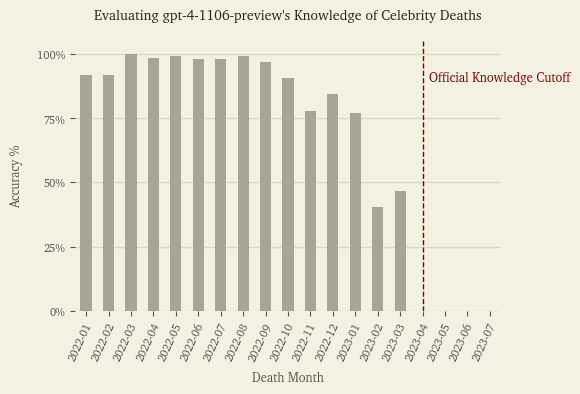

In [58]:
matplotlib.rcParams['font.family'] = 'Charter'

plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.set_facecolor('#f3f1e2')
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.yaxis.grid(True, color='#DAD8C9', linestyle='-', linewidth=1)

accuracy_by_death_month_df.plot(kind='bar', ax=ax, x='year_month', y='accuracy_percent', figsize=(5.5, 3.5), color='#A7A596', zorder=2, legend=False)

ax.grid(color='#f3f1e2', axis='x', linestyle='-', linewidth=2)
plt.gcf().set_facecolor('#f3f1e2')

plt.title(f'Evaluating {model_name}\'s Knowledge of Celebrity Deaths', fontsize=10, color='#272516', y=1.05)
plt.xlabel('Death Month', fontsize=9, color='#5A5849', labelpad=6)
plt.ylabel('Accuracy %', fontsize=9, color='#5A5849', labelpad=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=65, fontsize=8)
plt.yticks(fontsize=8)

offset = transforms.ScaledTranslation(-4/72, 0, plt.gcf().dpi_scale_trans)

for label in plt.gca().get_xticklabels():
    label.set_transform(label.get_transform() + offset)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Indicate its knowledge cutoff
knowledge_cutoff_year_month = official_knowledge_cutoff[:7]
bar_index = chart_data_df[chart_data_df['year_month'] == knowledge_cutoff_year_month].index[0]
ax.axvline(x=bar_index, color='#800000', linewidth=1, zorder=1, linestyle='--')
bar_index = accuracy_by_year_month[chart_data_df['year_month'] == knowledge_cutoff_year_month].index[0]
ax.text(bar_index + 0.3, plt.gca().get_ylim()[1] * 0.85, "Official Knowledge Cutoff", color='#800000', ha='left', fontsize=9)

plt.savefig('output/accuracy_chart.png', bbox_inches='tight')

plt.show()